In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pickle
import numpy as np
import cv2
import os
from collections import namedtuple

# (NOTE! this is taken from the official Cityscapes scripts:)
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

# (NOTE! this is taken from the official Cityscapes scripts:)
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      19 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      19 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      19 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      19 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      19 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      19 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      19 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      19 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      19 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      19 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]



# create a function which maps id to trainId:
id_to_trainId = {label.id: label.trainId for label in labels}
id_to_trainId_map_func = np.vectorize(id_to_trainId.get)

train_dirs = ["jena/", "zurich/", "weimar/", "ulm/", "tubingen/", "stuttgart/",
              "strasbourg/", "monchengladbach/", "krefeld/", "hanover/",
              "hamburg/", "erfurt/", "dusseldorf/", "darmstadt/", "cologne/",
              "bremen/", "bochum/", "aachen/"]
val_dirs = ["frankfurt/", "munster/", "lindau/"]
test_dirs = ["berlin", "bielefeld", "bonn", "leverkusen", "mainz", "munich"]

# For Colab
cityscapes_data_path = "/content/drive/MyDrive/Datasets/Cityscapes"
cityscapes_meta_path = "/content/drive/MyDrive/Datasets/Cityscapes/meta"

### Added by JS ###
#cityscapes_data_path = "C:/Users/Lenovo/Documents/Thesis/Datasets/CityScapes"
#cityscapes_meta_path = "C:/Users/Lenovo/Documents/Thesis/Datasets/CityScapes/meta"
### ___________ ###


if not os.path.exists(cityscapes_meta_path):
    os.makedirs(cityscapes_meta_path)
if not os.path.exists(cityscapes_meta_path + "/label_imgs"):
    os.makedirs(cityscapes_meta_path + "/label_imgs")
if not os.path.exists(cityscapes_meta_path + "/bias_labels"):
    os.makedirs(cityscapes_meta_path + "/bias_labels")

################################################################################
# convert all labels to label imgs with trainId pixel values (and save to disk):
################################################################################
train_label_img_paths = []

img_dir = cityscapes_data_path + "/leftImg8bit/train/"
label_dir = cityscapes_data_path + "/gtFine/train/"

# for train_dir in train_dirs:
#     print (train_dir)

#     train_img_dir_path = img_dir + train_dir
#     train_label_dir_path = label_dir + train_dir

#     file_names = os.listdir(train_img_dir_path)
#     for file_name in file_names:
#         img_id = file_name.split("_leftImg8bit.png")[0]

#         gtFine_img_path = train_label_dir_path + img_id + "_gtFine_labelIds.png"
#         gtFine_img = cv2.imread(gtFine_img_path, -1) # (shape: (1024, 2048))

#         # convert gtFine_img from id to trainId pixel values:
#         label_img = id_to_trainId_map_func(gtFine_img) # (shape: (1024, 2048))
#         label_img = label_img.astype(np.uint8)

#         #cv2.imwrite(cityscapes_meta_path + "/label_imgs/" + img_id + ".png", label_img)
#         #train_label_img_paths.append(cityscapes_meta_path + "/label_imgs/" + img_id + ".png")

#         #*** adding colour labels *** for visual inspection only were going to slot these into the dataloaders get_item function eventually then its just created on the fly... 

#         raw_img_path = train_img_dir_path + file_name
#         raw_img = cv2.imread(raw_img_path, -1) # (shape: (1024, 2048))
      
#         bias_label = torch.from_numpy(np.transpose(raw_img,(2,0,1)))
#         bias_label = torch.div(bias_label,32)  
#         bias_label = bias_label.long()
#         bias_label = bias_label.numpy()
#         bias_label = bias_label.transpose(1, 2, 0)

#         cv2.imwrite(cityscapes_meta_path + "/bias_labels/" + img_id + ".png", bias_label)
 
img_dir = cityscapes_data_path + "/leftImg8bit/val/"
label_dir = cityscapes_data_path + "/gtFine/val/"

for val_dir in val_dirs:
    print (val_dir)

    val_img_dir_path = img_dir + val_dir
    val_label_dir_path = label_dir + val_dir

    file_names = os.listdir(val_img_dir_path)
    for file_name in file_names:
        img_id = file_name.split("_leftImg8bit.png")[0]

        gtFine_img_path = val_label_dir_path + img_id + "_gtFine_labelIds.png"
        gtFine_img = cv2.imread(gtFine_img_path, -1) # (shape: (1024, 2048))

        # convert gtFine_img from id to trainId pixel values:
        label_img = id_to_trainId_map_func(gtFine_img) # (shape: (1024, 2048))
        label_img = label_img.astype(np.uint8)

        #cv2.imwrite(cityscapes_meta_path + "/label_imgs/" + img_id + ".png", label_img)
       
       #*** adding colour labels *** for visual inspection only were going to slot these into the dataloaders get_item function eventually then its just created on the fly... 

        raw_img_path = val_img_dir_path + file_name
        raw_img = cv2.imread(raw_img_path, -1) # (shape: (1024, 2048))
      
        bias_label = torch.from_numpy(np.transpose(raw_img,(2,0,1)))
        bias_label = torch.div(bias_label,32)  
        bias_label = bias_label.long()
        bias_label = bias_label.numpy()
        bias_label = bias_label.transpose(1, 2, 0)

        cv2.imwrite(cityscapes_meta_path + "/bias_labels/" + img_id + ".png", bias_label)
################################################################################
# compute the class weights:
################################################################################
# print ("computing class weights")

# num_classes = 20

# trainId_to_count = {}
# for trainId in range(num_classes):
#     trainId_to_count[trainId] = 0

# # get the total number of pixels in all train label_imgs that are of each object class:
# for step, label_img_path in enumerate(train_label_img_paths):
#     if step % 100 == 0:
#         print (step)

#     label_img = cv2.imread(label_img_path, -1)

#     for trainId in range(num_classes):
#         # count how many pixels in label_img which are of object class trainId:
#         trainId_mask = np.equal(label_img, trainId)
#         trainId_count = np.sum(trainId_mask)

#         # add to the total count:
#         trainId_to_count[trainId] += trainId_count

# # compute the class weights according to the ENet paper:
# class_weights = []
# total_count = sum(trainId_to_count.values())
# for trainId, count in trainId_to_count.items():
#     trainId_prob = float(count)/float(total_count)
#     trainId_weight = 1/np.log(1.02 + trainId_prob)
#     class_weights.append(trainId_weight)

# print (class_weights)

# with open(cityscapes_meta_path + "/class_weights.pkl", "wb") as file:
#     pickle.dump(class_weights, file)#, protocol=2) # (protocol=2 is needed to be able to open this file with python2)

frankfurt/
munster/
lindau/


In [ ]:
# Check the number of preprocessed images is the same as the raw ones otherwise we will run into trouble later:
raw_train = sum(len(files) for _, _, files in os.walk(cityscapes_data_path + '/leftImg8bit/train'))
raw_val = sum(len(files) for _, _, files in os.walk(cityscapes_data_path + '/leftImg8bit/val'))

print('Total number of raw images:                     ', raw_train + raw_val )

label_total = sum(len(files) for _, _, files in os.walk(cityscapes_meta_path + '/label_imgs'))
print('Total number of label images for segmentation:  ', label_total )

bias_total = sum(len(files) for _, _, files in os.walk(cityscapes_meta_path + '/bias_labels'))
print('Total number of bias labels for 2nd head:       ', bias_total )

Total number of raw images:                      3475
Total number of label images for segmentation:   3475
Total number of bias labels for 2nd head:        3475


jena/
jena_000032_000019_leftImg8bit.png
Shape: (1024, 2048, 3)
************************************
tensor([[[21, 21, 21,  ..., 14, 15, 15],
         [19, 20, 20,  ..., 15, 15, 15],
         [19, 19, 19,  ..., 15, 14, 13],
         ...,
         [73, 73, 73,  ..., 59, 59, 59],
         [73, 73, 73,  ..., 57, 57, 58],
         [73, 73, 73,  ..., 55, 54, 55]],

        [[32, 32, 33,  ..., 15, 16, 16],
         [32, 32, 32,  ..., 16, 16, 16],
         [34, 33, 33,  ..., 16, 16, 16],
         ...,
         [83, 83, 84,  ..., 71, 70, 71],
         [83, 83, 84,  ..., 68, 68, 69],
         [83, 83, 84,  ..., 65, 65, 66]],

        [[20, 20, 21,  ..., 11, 11, 11],
         [19, 19, 20,  ..., 11, 12, 12],
         [20, 20, 20,  ..., 11, 11, 12],
         ...,
         [64, 65, 67,  ..., 57, 56, 55],
         [64, 65, 67,  ..., 55, 54, 54],
         [64, 65, 67,  ..., 51, 49, 50]]], dtype=torch.uint8)
************************************
tensor([[[0.6562, 0.6562, 0.6562,  ..., 0.4375, 0.4688, 0

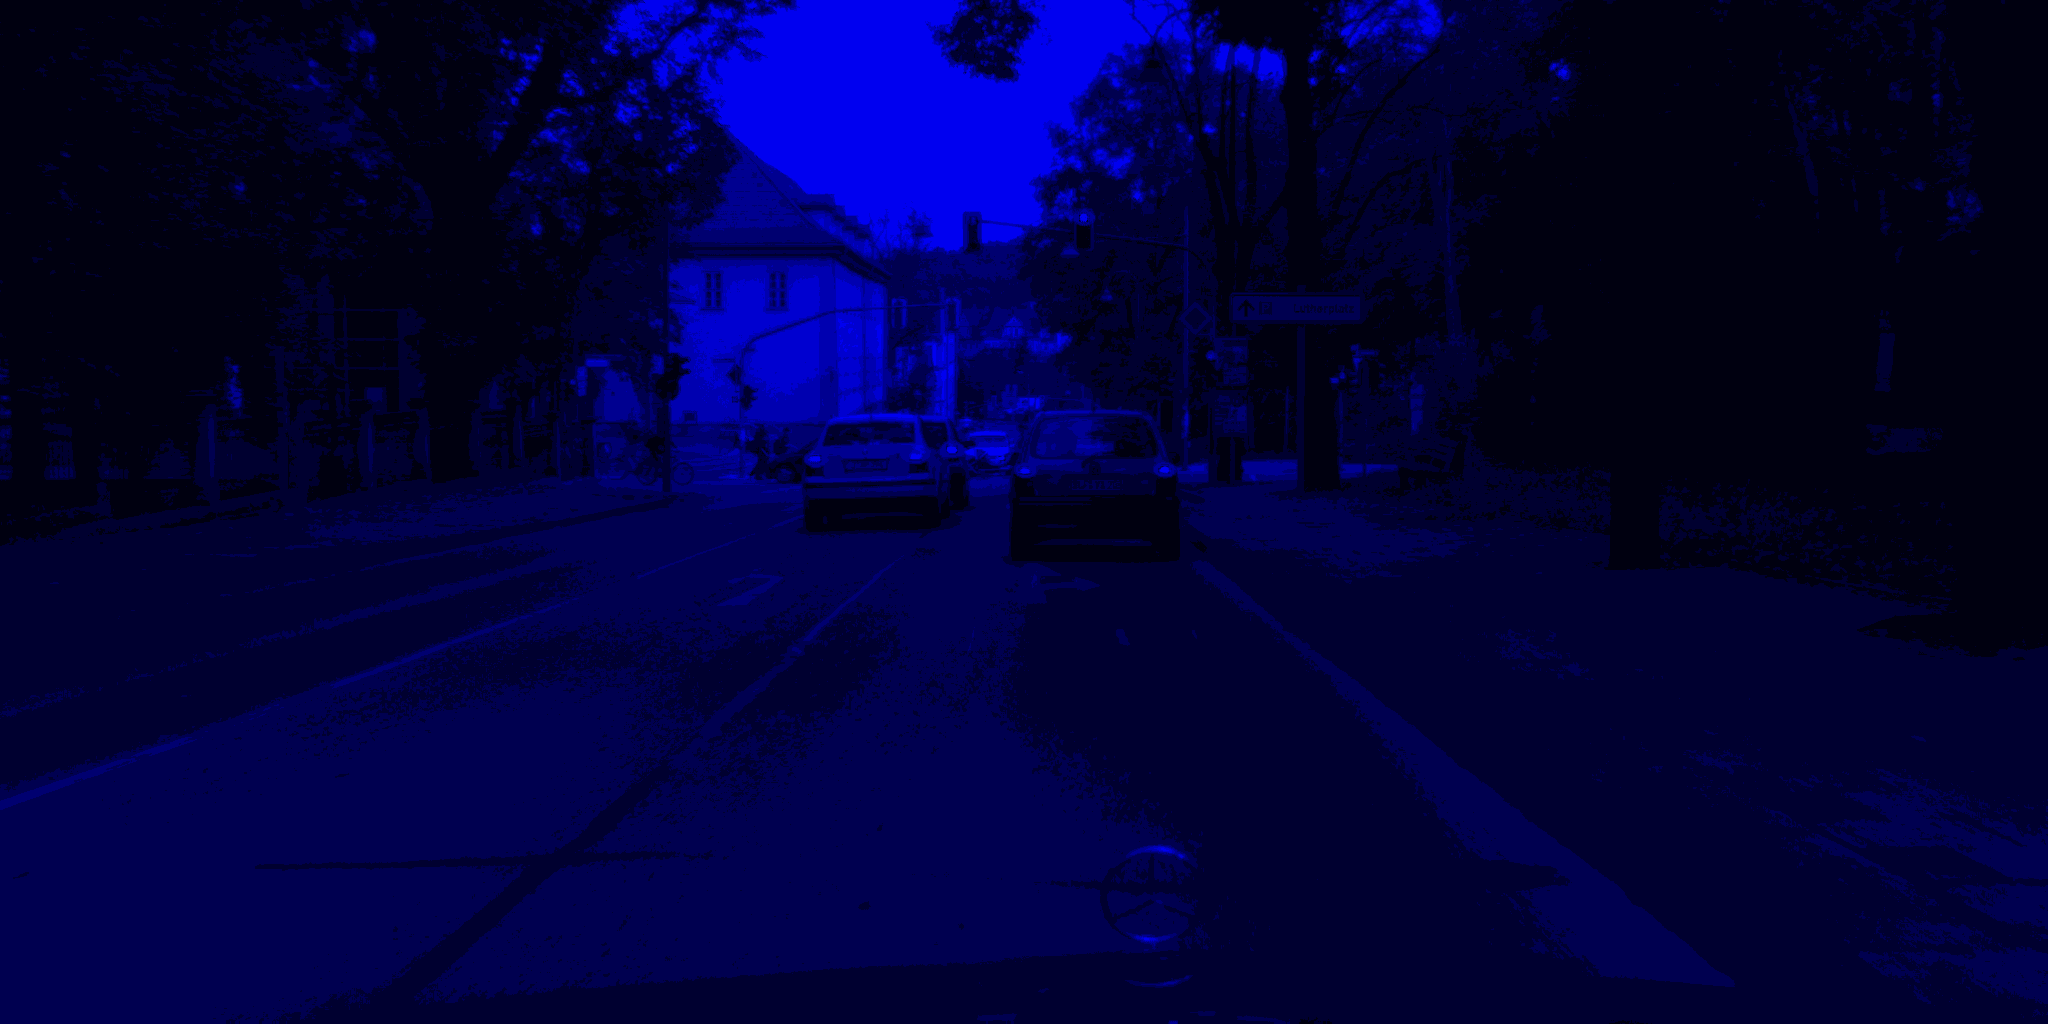

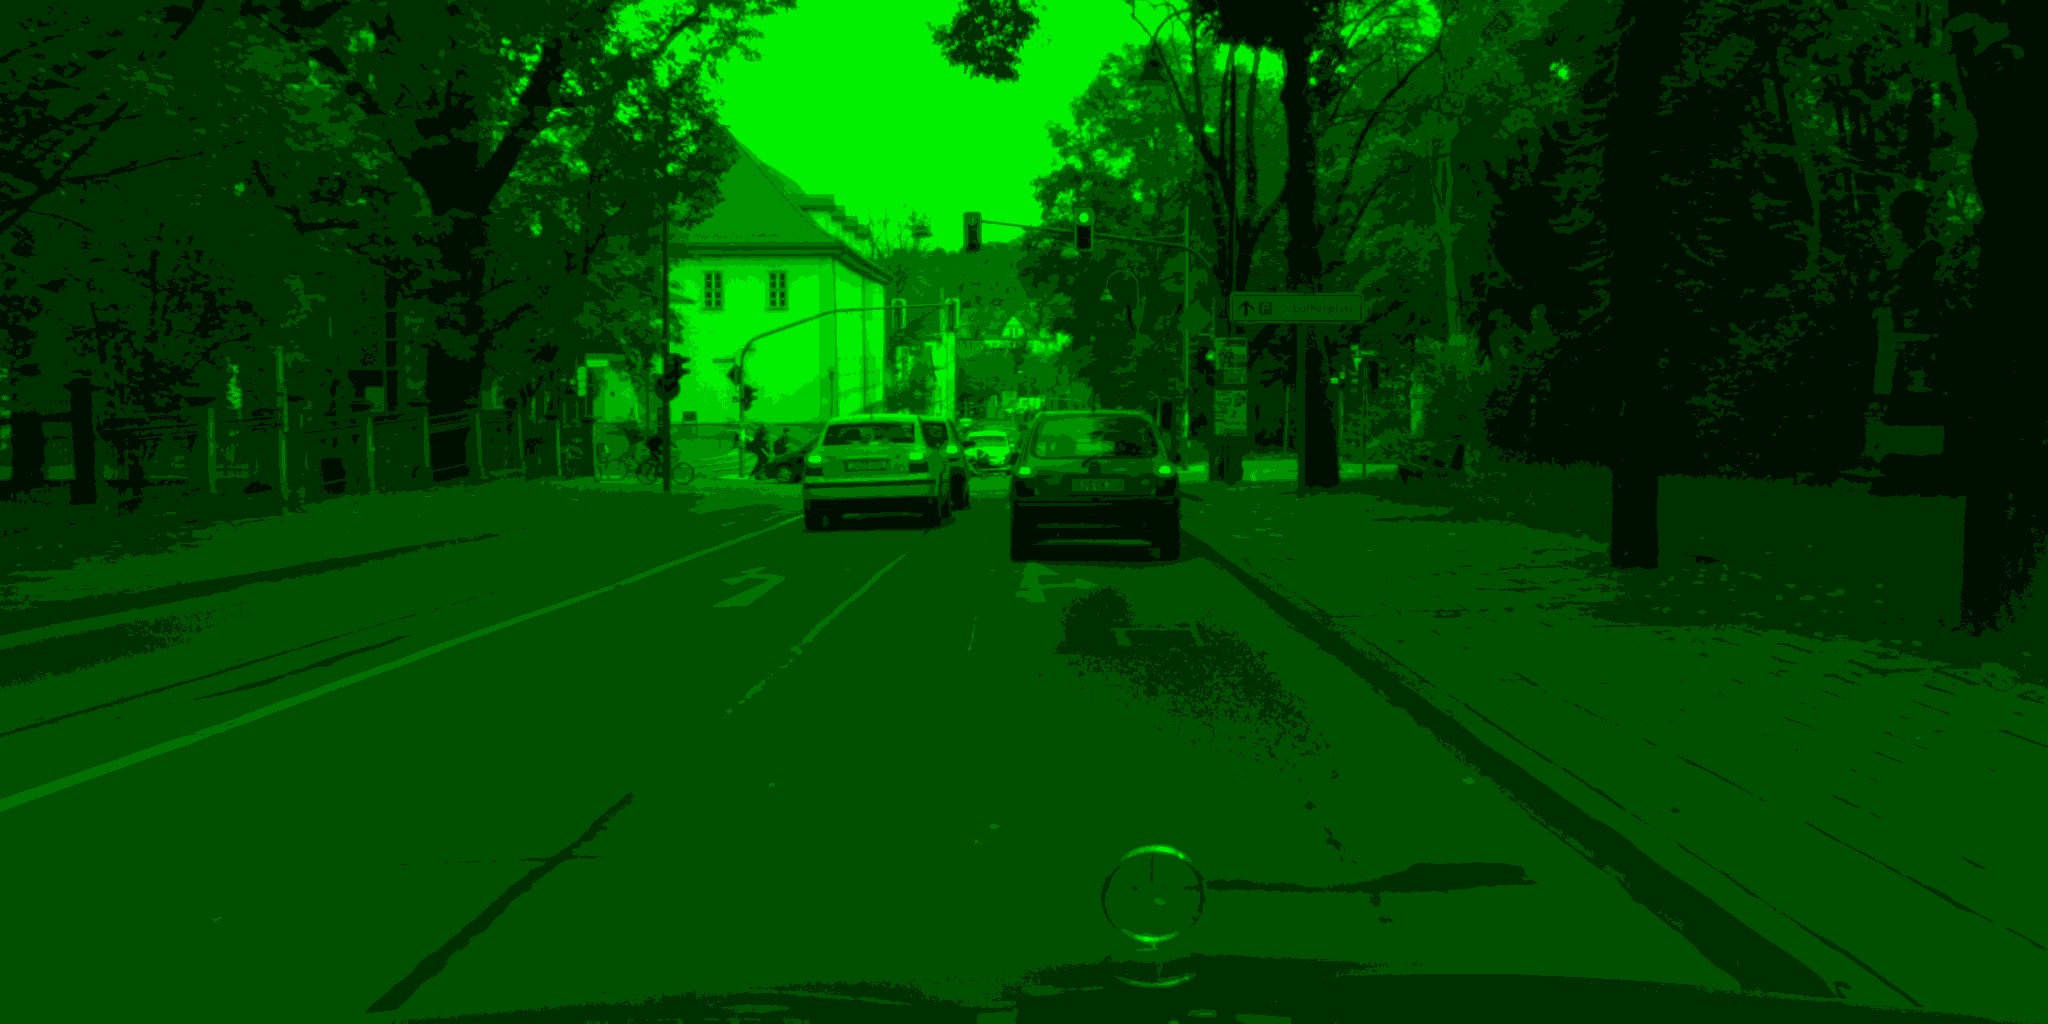

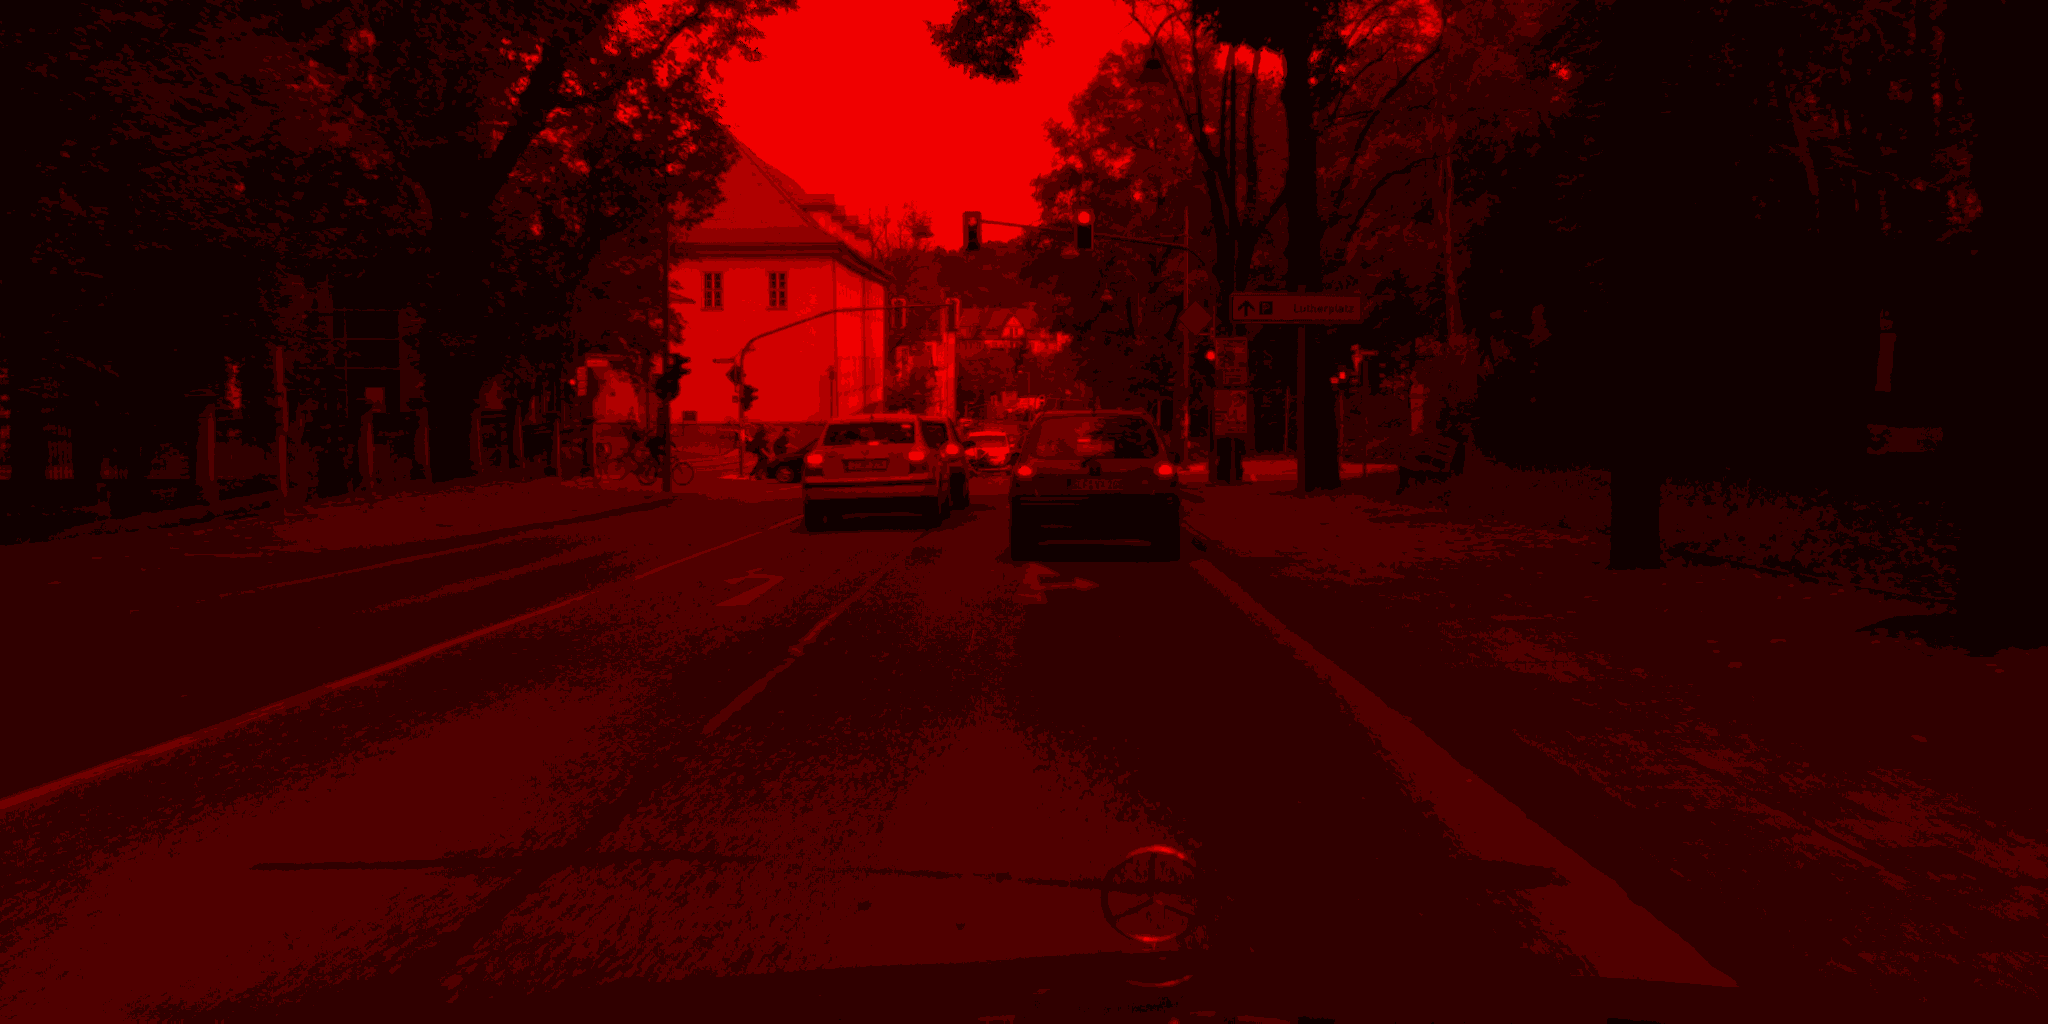

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


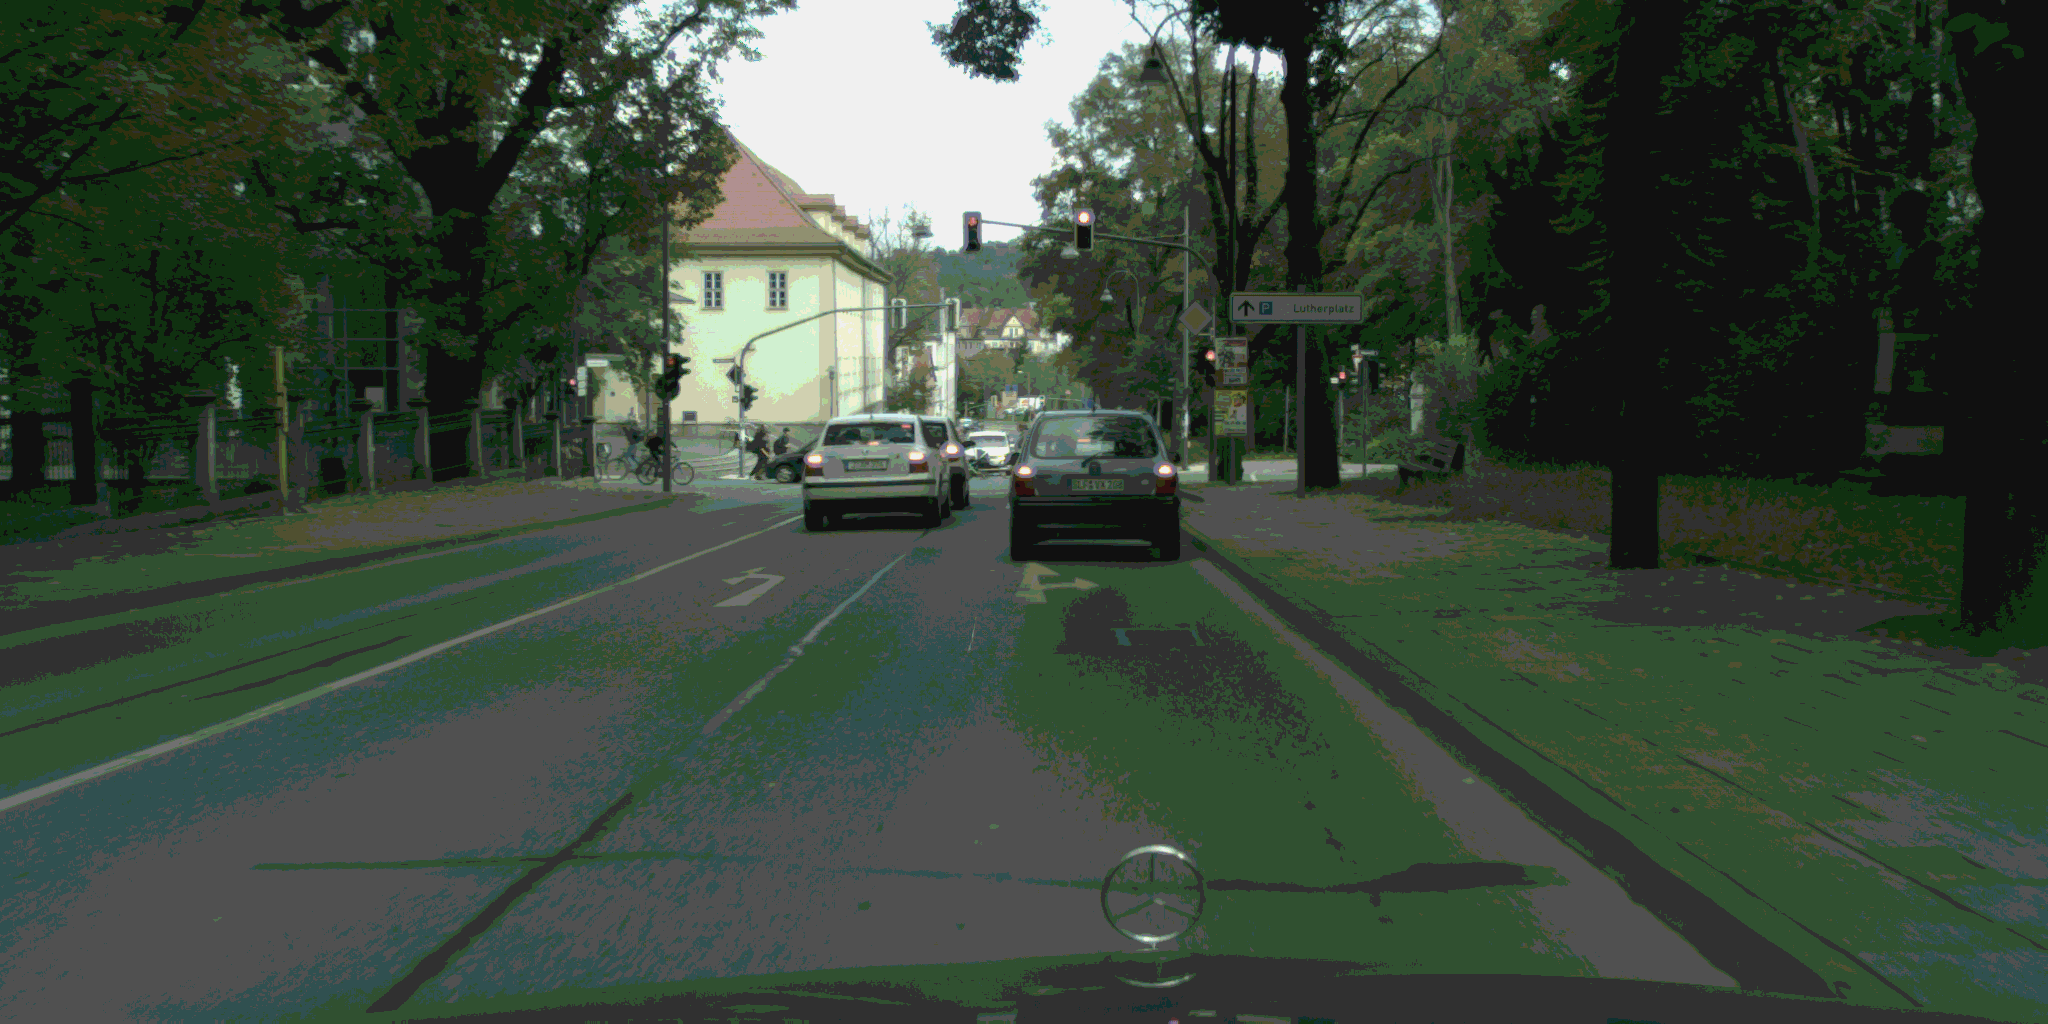

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [ ]:
import pickle
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os
import torch


train_dirs = ["jena/", "zurich/", "weimar/", "ulm/", "tubingen/", "stuttgart/",
              "strasbourg/", "monchengladbach/", "krefeld/", "hanover/",
              "hamburg/", "erfurt/", "dusseldorf/", "darmstadt/", "cologne/",
              "bremen/", "bochum/", "aachen/"]
val_dirs = ["frankfurt/", "munster/", "lindau/"]
test_dirs = ["berlin", "bielefeld", "bonn", "leverkusen", "mainz", "munich"]

# For Colab
cityscapes_data_path = "/content/drive/MyDrive/Datasets/Cityscapes"
cityscapes_meta_path = "/content/drive/MyDrive/Datasets/Cityscapes/meta"

if not os.path.exists(cityscapes_meta_path):
    os.makedirs(cityscapes_meta_path)
if not os.path.exists(cityscapes_meta_path + "/label_imgs"):
    os.makedirs(cityscapes_meta_path + "/label_imgs")
if not os.path.exists(cityscapes_meta_path + "/bias_imgs"):
    os.makedirs(cityscapes_meta_path + "/bias_imgs")

################################################################################
# convert all labels to label imgs with trainId pixel values (and save to disk):
################################################################################
train_label_img_paths = []

img_dir = cityscapes_data_path + "/leftImg8bit/train/"
label_dir = cityscapes_data_path + "/gtFine/train/"

for train_dir in train_dirs:
    print (train_dir)

    train_img_dir_path = img_dir + train_dir
    train_label_dir_path = label_dir + train_dir

    file_names = os.listdir(train_img_dir_path)
    for file_name in file_names:
        print(file_name)
        
        raw_img_path = train_img_dir_path + file_name
        raw_img = cv2.imread(raw_img_path, -1) # (shape: (1024, 2048))
        print('Shape:', raw_img.shape) 
        # testing
        #cv2_imshow(raw_img)
        #cv2.waitKey(0)
        # -------
        

        bias_label = torch.from_numpy(np.transpose(raw_img,(2,0,1)))
        print('************************************')
        print(bias_label)
        #print('Shape:', bias_label.shape)  
        #mask_image = torch.lt(bias_label.float()-0.00001, 0.) * 255
        #print('************************************')
        #print(mask_image)
        bias_label = torch.div(bias_label,32)
        print('************************************')
        print(bias_label)
        print('Shape:', bias_label.shape) 
        #bias_label = bias_label + mask_image
        #print('************************************')
        #print(bias_label)
        print('Shape:', bias_label.shape) 
        bias_label = bias_label.long()
        print('************************************')
        print(bias_label)
        print('Shape:', bias_label.shape) 
        
        # Produed an interpretation of the images that we use as ground truths

        labels = (bias_label*32)+16
        print('************************************')
        print('Sanity Check')
        print(torch.max(labels))
        print(torch.max(bias_label))
      
        b = labels.clone().detach().numpy()
        print(b.shape)
        b=b.transpose(1, 2, 0)
        # set green and red channels to 0
        b[:, :, 1] = 0
        b[:, :, 2] = 0
        print(b.shape)

        g = labels.clone().detach().numpy()
        g=g.transpose(1, 2, 0)
        # set blue and red channels to 0
        g[:, :, 0] = 0
        g[:, :, 2] = 0

        r = labels.clone().detach().numpy()
        r=r.transpose(1, 2, 0)
        # set blue and green channels to 0
        r[:, :, 0] = 0
        r[:, :, 1] = 0

        # RGB - Blue
        cv2_imshow(b)
        # RGB - Green
        cv2_imshow(g)
        # RGB - Red
        cv2_imshow(r)
        
        labels = labels.numpy()
        labels = labels.transpose(1, 2, 0)
        cv2_imshow(labels)
        cv2.waitKey(0) # displays the image indefinately until the keyboard is pressed. cv2.waitKey(1) displays the image for 1ms.
        
        # -------
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
        break

    break

In [ ]:
## Testing the greyscale conversion:

import pickle
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os
import torch


train_dirs = ["jena/", "zurich/", "weimar/", "ulm/", "tubingen/", "stuttgart/",
              "strasbourg/", "monchengladbach/", "krefeld/", "hanover/",
              "hamburg/", "erfurt/", "dusseldorf/", "darmstadt/", "cologne/",
              "bremen/", "bochum/", "aachen/"]
val_dirs = ["frankfurt/", "munster/", "lindau/"]
test_dirs = ["berlin", "bielefeld", "bonn", "leverkusen", "mainz", "munich"]

# For Colab
cityscapes_data_path = "/content/drive/MyDrive/Datasets/Cityscapes"
cityscapes_meta_path = "/content/drive/MyDrive/Datasets/Cityscapes/meta"

img_dir = cityscapes_data_path + "/leftImg8bit/train/"
label_dir = cityscapes_data_path + "/gtFine/train/"

for train_dir in train_dirs:
    print(train_dir)

    train_img_dir_path = img_dir + train_dir
    #train_label_dir_path = label_dir + train_dir

    file_names = os.listdir(train_img_dir_path)
    for file_name in file_names:
        #print(file_name)
        
        raw_img_path = train_img_dir_path + file_name
        raw_img = cv2.imread(raw_img_path, -1) # (shape: (1024, 2048)) zero here for greyscale
        print('Shape:', raw_img.shape) 
        print(raw_img)
        # testing
        cv2_imshow(raw_img)
        cv2.waitKey(0)
        # -------
        
        # Covert to Greyscale:
        grey_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
        cv2_imshow(grey_img)
        print('Shape:', grey_img.shape) 
        print(grey_img)
        
        # This doesnt work \/
        grey_3_channels = cv2.cvtColor(grey_img, cv2.COLOR_GRAY2BGR)
        cv2_imshow(grey_img)
        print('Shape:', grey_img.shape) 
        print(grey_img)
        
        # what about loading in a grey image then doing this
        #grey_img = cv2.imread(raw_img_path, 0) # (shape: (1024, 2048)) zero here for greyscale

        # Cppy the grey channel and create a dummy RGB image and see how it looks. 

        dummy_RGB_images = np.ndarray(shape=(grey_img.shape[0], grey_img.shape[1], 3), dtype= np.uint8) 
        dummy_RGB_images[:, :, 0] = grey_img[:, :]
        dummy_RGB_images[:, :, 1] = grey_img[:, :]
        dummy_RGB_images[:, :, 2] = grey_img[:, :] 

        cv2_imshow(dummy_RGB_images)
        print('Shape: this one', dummy_RGB_images.shape) 
        print(dummy_RGB_images[1])
        
        ''' https://stackoverflow.com/questions/37203970/opencv-grayscale-mode-vs-gray-color-conversion
        link also shows that theres descrepency between the different methods. Negligable in reality.  
        '''
        grey_img_expanded = np.expand_dims(grey_img, 2)
        print('Shape:', grey_img_expanded.shape) 

        dummy_RGB_images = np.ndarray(shape=(grey_img.shape[0], grey_img.shape[1], 3), dtype= np.uint8) 
        dummy_RGB_images[:, :, 0] = grey_img_expanded[:, :, 0]
        dummy_RGB_images[:, :, 1] = grey_img_expanded[:, :, 0]
        dummy_RGB_images[:, :, 2] = grey_img_expanded[:, :, 0] 

        cv2_imshow(dummy_RGB_images)
        print('Shape:', dummy_RGB_images.shape) 
        print(dummy_RGB_images)
        # This would be best slotted within the dataloaders and done on the fly. 
        
        # Test all code together:

        greyscale = False

        if greyscale: # Do we need an option argument to use this? 
            grey_img =  cv2.imread(raw_img_path, 0) # (shape: (1024, 2048))
            dummy_RGB_image = np.ndarray(shape=(grey_img.shape[0], grey_img.shape[1], 3), dtype= np.uint8) 
            dummy_RGB_image[:, :, 0] = grey_img[:, :]
            dummy_RGB_image[:, :, 1] = grey_img[:, :]
            dummy_RGB_image[:, :, 2] = grey_img[:, :]
            img = dummy_RGB_image  # (shape: (1024, 2048, 3)) grey values copied along all 3 channels for use in pretrained networks expecting 3 channel input
            print('Img:.......', img)
            cv2_imshow(img)
        else:
            img = cv2.imread(raw_img_path, -1) # (shape: (1024, 2048, 3))
            print('Img:.......', img)
            cv2_imshow(img)
        break
    break
 


Output hidden; open in https://colab.research.google.com to view.